In [1]:
import sys
sys.path.append('../')
import numpy as np
from IPython.display import HTML

from rover_simulator.core import *
from rover_simulator.collision_detector import *
from rover_simulator.utils.motion import state_transition
from rover_simulator.world import World
from rover_simulator.rover import BasicRover
from rover_simulator.history import SimpleHistory
from rover_simulator.sensor import ImaginalLiDAR
from rover_simulator.navigation.localizer import ImaginalLocalizer
from stable_baselines3 import PPO
from gymnasium import spaces
from gymnasium import Env

2025-01-16 12:59:52.624167: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 12:59:52.645842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-16 12:59:52.645861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-16 12:59:52.646380: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 12:59:52.650082: I tensorflow/core/platform/cpu_feature_guar

In [2]:
class RlRover(BasicRover):
    def __init__(
        self,
        pose: np.ndarray, radius: float,
        sensor: Sensor = None, localizer: Localizer = ImaginalLocalizer(),
        sensing_planner: SensingPlanner = SensingPlanner(), collision_detector: CollisionDetector = None,
        history: SimpleHistory = None,
        color: str = "black", waypoint_color: str = 'blue'
    ) -> None:
        super().__init__(pose, radius, sensor, localizer, None, None, sensing_planner, None, collision_detector, history, color, waypoint_color)

    def reset(self, x_range: list, y_range: list) -> None:
        x = np.random.uniform(x_range[0], x_range[1])
        y = np.random.uniform(y_range[0], y_range[1])
        th = np.random.uniform(-np.pi, np.pi)
        pose = np.array([x, y, th])
        pose = np.array([5, 5, 0])
        self.real_pose = pose
        self.estimated_pose = pose
        
class RobotNavigationEnv(Env):
    def __init__(self, world: World, rover: RlRover, world_range: list = [[0, 20], [0, 20]], min_v: float = 0.0, max_v: float = 1.0, min_w = -np.pi, max_w: float = np.pi):
        super(RobotNavigationEnv, self).__init__()
        self.world = world
        self.rover = rover
        self.x_range = world_range[0]
        self.y_range = world_range[1]
        self.action_space = spaces.Box(low=np.float32(np.array([min_v, min_w])), high=np.float32(np.array([max_v, max_w])))
        self.observation_space = spaces.Box(
            low=np.float32(np.array([0, -np.pi] + [0] * self.rover.sensor.smp_num)), 
            high=np.float32(np.array([20, np.pi] + [self.rover.sensor.range] * self.rover.sensor.smp_num)), 
        )
        self.goal = np.array([18.0, 18.0])
        
    def reset(self, seed=None, return_info=False, options=None):
        self.world.reset(reset_rovers=False, reset_obstacles=False)
        self.rover.reset(self.x_range, self.y_range)
        self.rover.history.reset()
    
        sensed_obstacles = self.rover.sensor.sense(self.rover)
        pts_dists = sensed_obstacles[:, 0]
        pts_dists = np.where(np.isinf(pts_dists), 100, pts_dists)
        
        dist_to_goal = np.linalg.norm(self.goal - self.rover.real_pose[:2])
        if dist_to_goal > 20:
            dist_to_goal = 20
        ang_to_goal = np.arctan2(self.goal[1] - self.rover.real_pose[1], self.goal[0] - self.rover.real_pose[0])
        while ang_to_goal < -np.pi:
            ang_to_goal += 2 * np.pi
        while ang_to_goal > np.pi:
            ang_to_goal -= 2 * np.pi
        state = np.concatenate([[dist_to_goal], [ang_to_goal], pts_dists])
        return state, {}
        
    def step(self, action):
        v, w = action
        self.rover.real_pose = state_transition(self.rover.real_pose, v, w, self.world.time_interval)

        done = False
        reward = 0
        sensed_obstacles = self.rover.sensor.sense(self.rover)
        self.rover.history.append(real_pose=self.rover.real_pose, estimated_pose=self.rover.estimated_pose, sensing_result=sensed_obstacles) if self.rover.history is not None else None
        
        pts_dists = sensed_obstacles[:, 0]
        pts_dists = np.where(np.isinf(pts_dists), 100, pts_dists)
        
        dist_to_goal = np.linalg.norm(self.goal - self.rover.real_pose[:2])
        if dist_to_goal > 20:
            dist_to_goal = 20
        ang_to_goal = np.arctan2(self.goal[1] - self.rover.real_pose[1], self.goal[0] - self.rover.real_pose[0])
        while ang_to_goal < -np.pi:
            ang_to_goal += 2 * np.pi
        while ang_to_goal > np.pi:
            ang_to_goal -= 2 * np.pi
            
        if self.rover.collision_detector.detect_collision(self.rover):
            reward = -1000
            done = True
        elif np.linalg.norm(self.rover.real_pose[:2] - self.goal) < 0.5:
            reward = 100
            done = True
        else:
            reward = -dist_to_goal
        reward -= 0.01
        
        
        next_state = np.concatenate([[dist_to_goal], [ang_to_goal], pts_dists])
        return next_state, reward, done, False, {}

    def render(self):
        # 描画が必要な場合、ここにコードを追加
        pass

In [3]:
world = World()
world.read_objects("./rover_simulator/examples/environment_simple.txt")

world.reset(reset_obstacles=False)

sensor = ImaginalLiDAR(obstacles=world.obstacles)
history = SimpleHistory(sensor=sensor)
rover = RlRover(
    np.array([1.0, 1.0, 0.0]), 0.5,
    sensor=sensor,
    localizer=ImaginalLocalizer(),
    collision_detector=CollisionDetector(world.obstacles),
    history=history,
)
world.append_rover(rover)

In [10]:
env = RobotNavigationEnv(world, rover)
total_timesteps = 3e8
total_timesteps = 1e4

model = PPO("MlpPolicy", env, verbose=0, device="cpu")
_ = model.learn(total_timesteps=total_timesteps, progress_bar=True)

Output()

In [11]:
env.rover.history.reset()
obs, _ = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, reward, done, _, info = env.step(action)
    if done:
        break
print("Test completed!")

Test completed!


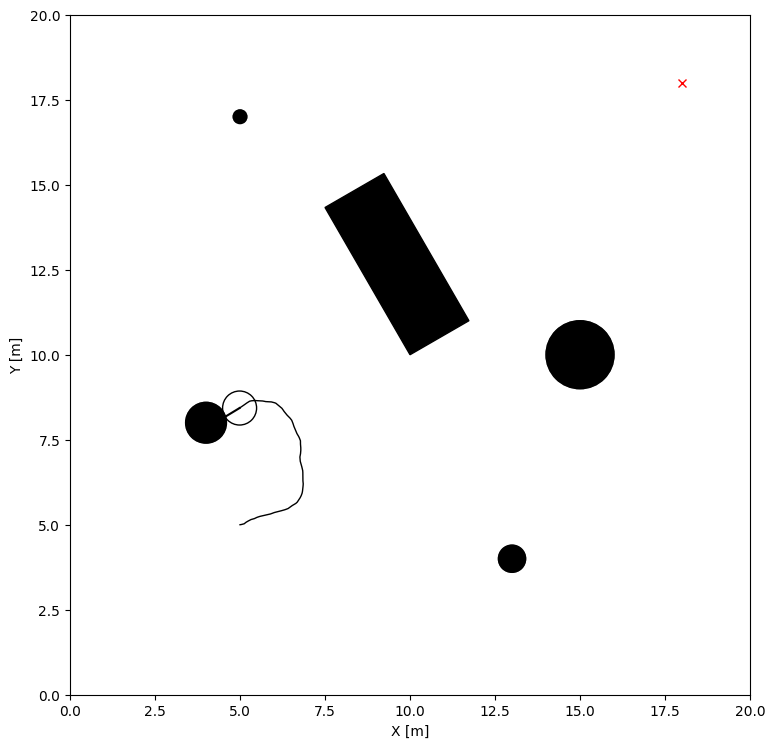

In [12]:
world.draw(xlim=[0, 20], ylim=[0, 20], goal_pos=env.goal)